# Statistical Data Analysis - Overview

The purpose of this notebook is to use statistical analysis to generate insights into the energy availability and weather forecast variable data. Previously, data wrangling and data storytelling have been performed on the data - these analyses are available at the following address: https://github.com/connormca12/Springboard-Projects/tree/master/Capstone-1

## Statistical Tests Performed:
- Correlation matrix 
- Bootstrap inference CHER Station July 1994-2007
- Bootstrap inference CHER Station January 1994-2007
- Bayesian inference CHER Station January 1994-2007 (combination of 3 normal distributions)
- Bayesian inference CHER Station January 1994-2007 (combination of 2 normal distributions)

# Data importing and organization

In [1]:
# Import necessary modules

import numpy as np
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
import scipy.stats as stats
from IPython.core.pylabtools import figsize
from mpl_toolkits.basemap import Basemap, cm
import seaborn as sns
import xarray as xr
import glob
import heatmap

C:\Users\conno\Anaconda3\envs\Springboard\lib\site-packages\dask\config.py:168: YAMLLoadWarning:

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.

C:\Users\conno\Anaconda3\envs\Springboard\lib\site-packages\distributed\config.py:20: YAMLLoadWarning:

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.



In [2]:
# Import the station location data and station energy data

# Station data is the list of 98 Mesonet solar farm IDs, their location (longitude, latitude, elevation)
stations = pd.read_csv('station_info.csv')

# Energy data is the total daily energy availability on each day for each station
energy = pd.read_csv('train.csv', parse_dates=True, index_col='Date')

In [3]:
# Import the weather variable forecasts
# Forecasts are separated into 15 different files for each forecast variable (e.g. air pressure, specific humidity, etc.)
# Each variable is forecast using 11 different predictive models at 144 gridpoint locations
# (on 16 lines of longitude and 9 lines of latitude)

# Take any filename that ends in .nc and add to a list of the files
weather_file_list = glob.glob('*.nc')

# Take the data from each file in the file list and put into a list of data
list_of_data = [xr.open_dataset(filename) for filename in weather_file_list]

# Convert list of data to a list of dataframes
# Each dataframe consists of forecast data for a single weather variable
list_of_dfs = [data_file.to_dataframe() for data_file in list_of_data]

In [4]:
# Load previously organized data - includes energy availability for each day at each station and the associated weather
# variable forecasts
EDA_data = pd.read_csv('ML_dataset_filtered.csv')
del EDA_data['index']
EDA_data['Date'] = pd.to_datetime(EDA_data['Date'])

# 
del EDA_data['year']
del EDA_data['month']
del EDA_data['day']
del EDA_data['Date']
del EDA_data['stid']

In [5]:
EDA_data.head(5)

,energy,nlat,elon,elev,apcp_sfc_fhour0,apcp_sfc_fhour1,apcp_sfc_fhour2,apcp_sfc_fhour3,apcp_sfc_fhour4,dlwrf_sfcfhour0,...,ulwrf_tatfhour0,ulwrf_tatfhour1,ulwrf_tatfhour2,ulwrf_tatfhour3,ulwrf_tatfhour4,uswrf_sfcfhour0,uswrf_sfcfhour1,uswrf_sfcfhour2,uswrf_sfcfhour3,uswrf_sfcfhour4
0,12384900,34.80833,261.97675,397,0.0,0.0,0.0,0.00,0.0,256.01898,...,244.59988,250.69777,253.00000,263.59940,260.80518,0.0,9.0,49.0,107.0,74.0
1,11908500,34.80833,261.97675,397,0.0,0.0,0.0,0.01,0.1,258.01898,...,229.67752,232.06482,232.53503,231.00787,232.05087,0.0,8.0,35.0,73.0,49.0
2,12470700,34.80833,261.97675,397,0.0,0.0,0.0,0.00,0.0,219.61050,...,239.21625,232.01129,235.49771,252.00594,247.46686,0.0,9.0,50.0,111.0,75.0
3,12725400,34.80833,261.97675,397,0.0,0.0,0.0,0.00,0.0,266.24475,...,231.95552,243.53894,245.44907,254.23553,250.00110,0.0,9.0,50.0,112.0,77.0
4,10894800,34.80833,261.97675,397,0.0,0.0,0.0,0.00,0.0,238.19739,...,235.53577,235.32010,242.18672,258.26974,241.10945,0.0,8.0,48.0,107.0,71.0


In [6]:
# Extract only forecast hour 0 for the purposes of the below analysis
EDA_data_t0 = EDA_data

for col in EDA_data_t0.columns:
    if str(col)[-6:-1] == 'fhour':
        if str(col)[-1] != '0':
            del EDA_data_t0[col]

In [7]:
EDA_data_t0.head()

,energy,nlat,elon,elev,apcp_sfc_fhour0,dlwrf_sfcfhour0,dswrf_sfcfhour0,pres_msl_fhour0,pwat_eatmfhour0,spfh_2m_lfhour0,tcdc_eatmfhour0,tcolc_eatfhour0,tmax_2m_lfhour0,tmin_2m_lfhour0,tmp_2m_lafhour0,tmp_sfc_lfhour0,ulwrf_sfcfhour0,ulwrf_tatfhour0,uswrf_sfcfhour0
0,12384900,34.80833,261.97675,397,0.0,256.01898,0.0,101932.83,5.951913,0.002450,0.00,0.0027,281.40515,279.41410,279.40988,277.62256,342.00000,244.59988,0.0
1,11908500,34.80833,261.97675,397,0.0,258.01898,0.0,101288.09,12.491788,0.003480,0.06,0.0579,279.74844,277.99658,278.07486,276.92682,335.00000,229.67752,0.0
2,12470700,34.80833,261.97675,397,0.0,219.61050,0.0,102354.28,4.800000,0.002230,0.00,0.0000,275.54425,270.73343,270.73553,270.18805,312.00000,239.21625,0.0
3,12725400,34.80833,261.97675,397,0.0,266.24475,0.0,102302.74,6.244365,0.002610,0.00,0.0002,281.28705,276.37952,276.45300,275.19394,338.74017,231.95552,0.0
4,10894800,34.80833,261.97675,397,0.0,238.19739,0.0,101574.55,10.100129,0.002802,0.00,0.0019,274.47516,273.96710,274.42460,273.34113,315.19788,235.53577,0.0


# Correlation Matrix
- The purpose of a correlation matrix is to visualize the correlation between variables.
- The Pearson correlation coefficient is calculated for each variable with every other variable - The results are plotted as a matrix.
- The variables analyzed below are the daily energy, and each of the weather variables at forecast hour 0.

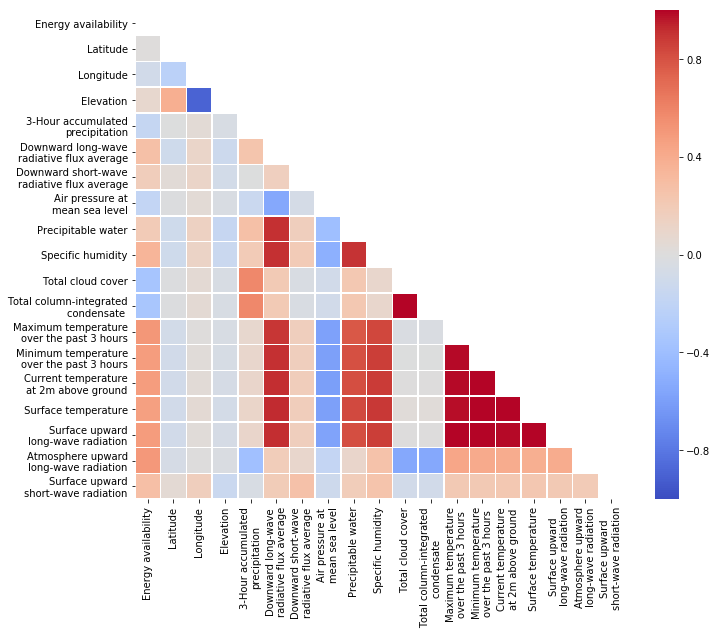

In [8]:
# Compute the correlation matrix
corr = EDA_data_t0.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set column labels
column_labels = ['Energy availability', 'Latitude', 'Longitude', 'Elevation','3-Hour accumulated\nprecipitation', 'Downward long-wave\nradiative flux average','Downward short-wave\nradiative flux average', 'Air pressure at\nmean sea level','Precipitable water', 'Specific humidity','Total cloud cover', 'Total column-integrated\ncondensate ','Maximum temperature\nover the past 3 hours', 'Minimum temperature\nover the past 3 hours','Current temperature\nat 2m above ground', ' Surface temperature','Surface upward\nlong-wave radiation', 'Atmosphere upward\nlong-wave radiation','Surface upward\nshort-wave radiation']

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, xticklabels=column_labels, yticklabels=column_labels)

plt.show()

- Energy availability is correlated with most of the variables (positive or negative)
    - These correlations indicate the variables can be used as features in a machine learning model.
- Strong positive correlations are evident between many of the weather variables.
    - These strong correlations give information for use in machine learning model feature engineering.

### Alternative correlation matrix visualization

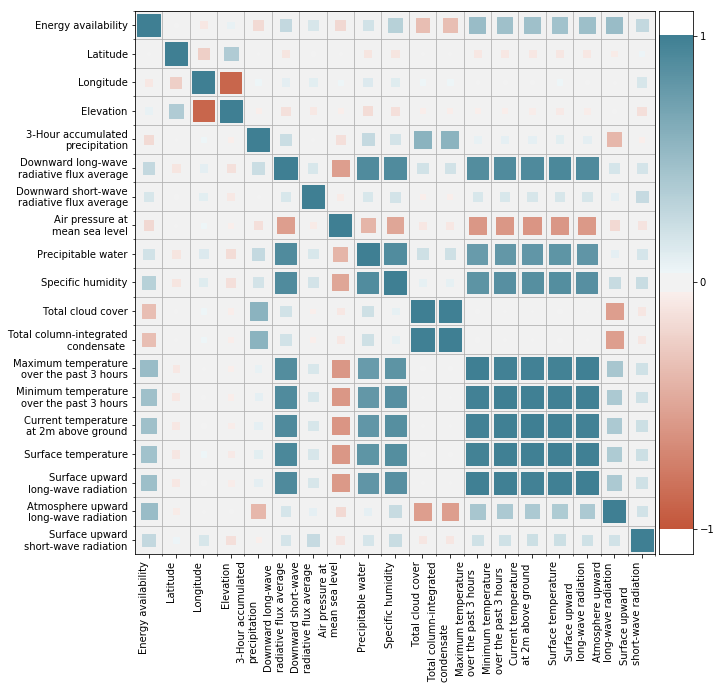

In [14]:
# Modified from: https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec
# https://github.com/drazenz/heatmap/blob/master/heatmap.py

# Plot heatmap using heatmap.corrplot function
plt.figure(figsize=(10, 10))
plt.xticks(range(EDA_data_t0.shape[1]), labels=column_labels, fontsize=18, rotation=90)
plt.yticks(range(EDA_data_t0.shape[1]), labels=column_labels, fontsize=18)
heatmap.corrplot(EDA_data_t0.corr(), labels=column_labels, size_scale=500)

# Bootstrap Inference
- It may be desired by a utility company to model the expected monthly and daily energy availability at a given station.
- As seen in EDA, the energy varies greatly by month, and thus it makes sense to model the daily energy by month.
- Below, we will model the daily energy for CHER station in July and January from 1994-2007.

In [201]:
# Reload data
EDA_data = pd.read_csv('ML_dataset_filtered.csv')
del EDA_data['index']
EDA_data['Date'] = pd.to_datetime(EDA_data['Date'])

In [202]:
# Select CHER station and all days in July from 1994-2007
cher_july = EDA_data[EDA_data['stid'] == 'CHER'].set_index('Date', drop=True)
cher_july = cher_july[cher_july.index.month==7]

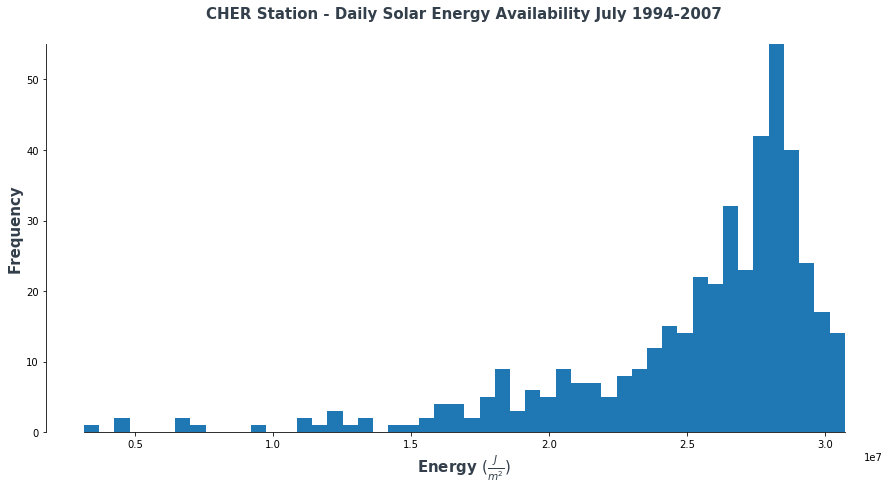

In [204]:
fig, ax = plt.subplots(figsize=(15,7.5))
plt.hist(cher_july['energy'], bins=50)

# Set titles and axes labels
ax.set_title("CHER Station - Daily Solar Energy Availability July 1994-2007", fontsize=15, fontweight='black', color = '#333F4B')
ax.set_xlabel(r'Energy $(\frac{J}{m^2})$', fontsize=15, fontweight='black', color = '#333F4B')
ax.set_ylabel('Frequency', fontsize=15, fontweight='black', color = '#333F4B')

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)

plt.show()

- The distribution of daily solar energy availability in July at CHER station has many values concentrated at the top of the distribution, and a long tail to 0. The distribution is certainly non-normal.
- The mean daily energy could be estimated using the mean of these samples, however we are interested in an estimate of the mean with uncertainty. Therefore, we should perform statistical bootstrapping. 

In [243]:
np.random.seed(47)
def energy_sampler(data, n):
    return np.random.choice(data, n)

In [685]:
# Take 10000 samples of the data of the same size and calculate the mean of each sample
energy_samples = pd.DataFrame({'meanenergy': [energy_sampler(cher_july['energy'] , len(cher_july['energy'])).mean() for i in range(10000)]})

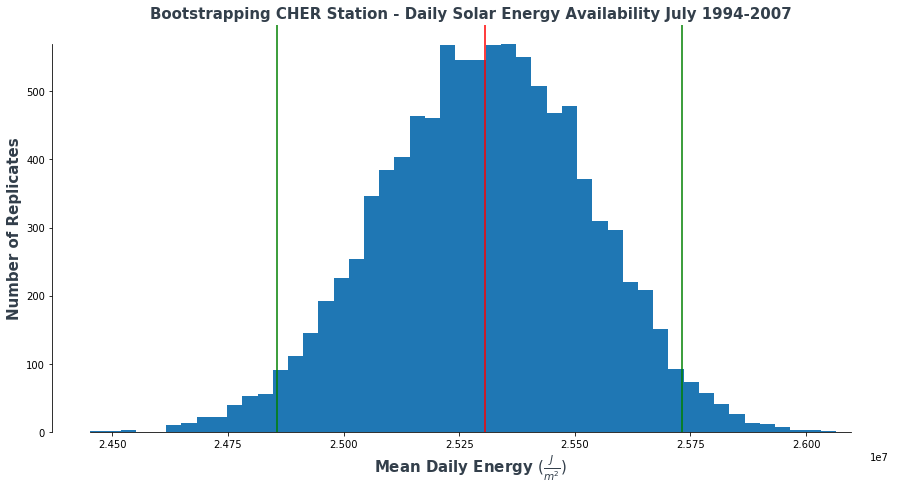

In [245]:
fig, ax = plt.subplots(figsize=(15,7.5))
plt.hist(energy_samples.meanenergy, bins=50)

# Set titles and axes labels
ax.set_title("Bootstrapping CHER Station - Daily Solar Energy Availability July 1994-2007", fontsize=15, fontweight='black', color = '#333F4B')
ax.set_xlabel(r'Mean Daily Energy $(\frac{J}{m^2})$', fontsize=15, fontweight='black', color = '#333F4B')
ax.set_ylabel('Number of Replicates', fontsize=15, fontweight='black', color = '#333F4B')

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)

energy_samples_mean = np.mean(energy_samples.meanenergy)
energy_samples_std = np.std(energy_samples.meanenergy)

_ = plt.axvline(energy_samples_mean, color='r')

conf_int = np.percentile(energy_samples.meanenergy, [2.5, 97.5])
_ = plt.axvline(conf_int[0], color='g', linestyle='-')
_ = plt.axvline(conf_int[1], color='g', linestyle='-')

plt.show()

In [246]:
print('Mean Daily Energy for July at CHER Station - 95% Confidence Interval:')
print(r'Lower: %.3E J/m^2' % conf_int[0])
print('Upper: %.3E J/m^2' % conf_int[1])

Mean Daily Energy for July at CHER Station - 95% Confidence Interval:
Lower: 2.486E+07 J/m^2
Upper: 2.573E+07 J/m^2


In [247]:
monthly_total = [conf_int[0] * 31, conf_int[1] * 31]

print('Expected Total Monthy Energy for July at CHER Station - 95% Confidence Interval:')
print('Lower: %.3E J/m^2' % monthly_total[0])
print('Upper: %.3E J/m^2' % monthly_total[1])

Expected Total Monthy Energy for July at CHER Station - 95% Confidence Interval:
Lower: 7.706E+08 J/m^2
Upper: 7.977E+08 J/m^2


In [248]:
population_std = energy_samples_std*np.sqrt(len(cher_july['energy']))
print('Population Standard Deviation: %.3E J/m^2' % population_std)

Population Standard Deviation: 4.698E+06 J/m^2


- We now have an estimate of the mean and a 95% confidence interval. Additionally, we have an estimate of the population standard deviation.

In [233]:
cher_jan = EDA_data[EDA_data['stid'] == 'CHER'].set_index('Date', drop=True)
cher_jan = cher_jan[cher_jan.index.month==1]

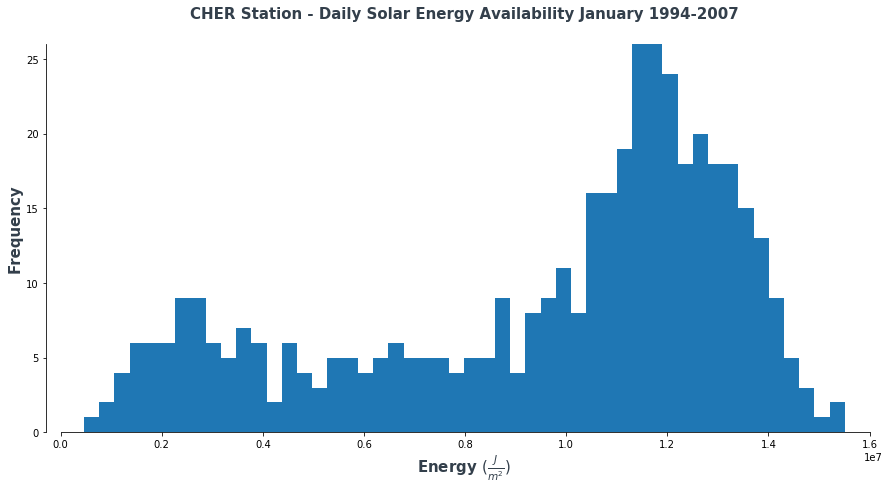

In [236]:
fig, ax = plt.subplots(figsize=(15,7.5))
plt.hist(cher_jan['energy'], bins=50)

# Set titles and axes labels
ax.set_title("CHER Station - Daily Solar Energy Availability January 1994-2007", fontsize=15, fontweight='black', color = '#333F4B')
ax.set_xlabel(r'Energy $(\frac{J}{m^2})$', fontsize=15, fontweight='black', color = '#333F4B')
ax.set_ylabel('Frequency', fontsize=15, fontweight='black', color = '#333F4B')

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)

plt.show()

In [693]:
# Take 10000 samples of the data of the same size and calculate the mean of each sample
energy_samples_jan = pd.DataFrame({'meanenergy': [energy_sampler(cher_jan['energy'] , len(cher_jan['energy'])).mean() for i in range(10000)]})
energy_samples.head()

,meanenergy
0,2.535574e+07
1,2.545078e+07
2,2.542509e+07
3,2.548439e+07
4,2.528448e+07


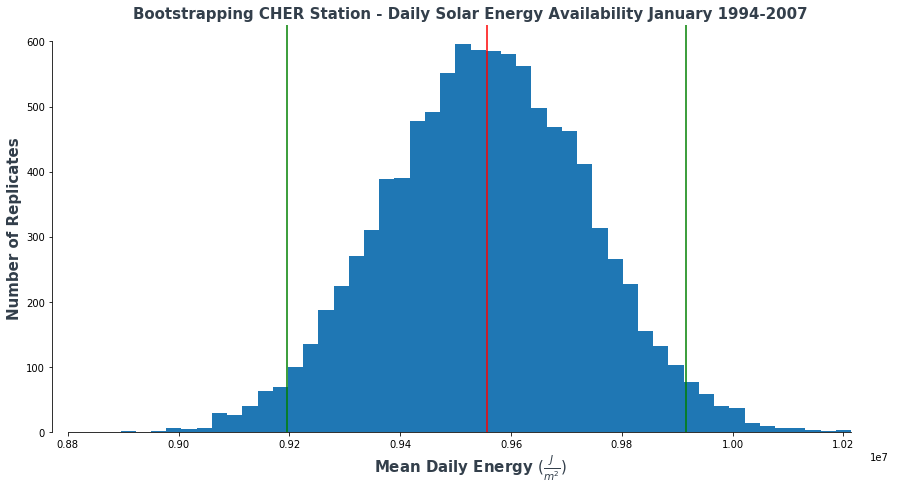

In [695]:
fig, ax = plt.subplots(figsize=(15,7.5))
plt.hist(energy_samples_jan.meanenergy, bins=50)

# Set titles and axes labels
ax.set_title("Bootstrapping CHER Station - Daily Solar Energy Availability January 1994-2007", fontsize=15, fontweight='black', color = '#333F4B')
ax.set_xlabel(r'Mean Daily Energy $(\frac{J}{m^2})$', fontsize=15, fontweight='black', color = '#333F4B')
ax.set_ylabel('Number of Replicates', fontsize=15, fontweight='black', color = '#333F4B')

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)

energy_samples_mean_jan = np.mean(energy_samples_jan.meanenergy)
energy_samples_std_jan = np.std(energy_samples_jan.meanenergy)

_ = plt.axvline(energy_samples_mean, color='r')

conf_int = np.percentile(energy_samples_jan.meanenergy, [2.5, 97.5])
_ = plt.axvline(conf_int[0], color='g', linestyle='-')
_ = plt.axvline(conf_int[1], color='g', linestyle='-')

plt.show()

In [252]:
print('Mean Daily Energy for January at CHER Station - 95% Confidence Interval:')
print(r'Lower: %.3E J/m^2' % conf_int[0])
print('Upper: %.3E J/m^2' % conf_int[1])

Mean Daily Energy for January at CHER Station - 95% Confidence Interval:
Lower: 9.196E+06 J/m^2
Upper: 9.907E+06 J/m^2


In [253]:
monthly_total = [conf_int[0] * 31, conf_int[1] * 31]

print('Expected Total Monthy Energy for January at CHER Station - 95% Confidence Interval:')
print('Lower: %.3E J/m^2' % monthly_total[0])
print('Upper: %.3E J/m^2' % monthly_total[1])

Expected Total Monthy Energy for January at CHER Station - 95% Confidence Interval:
Lower: 2.851E+08 J/m^2
Upper: 3.071E+08 J/m^2


In [254]:
population_std = energy_samples_std*np.sqrt(len(cher_jan['energy']))
print('Population Standard Deviation: %.3E J/m^2' % population_std)

Population Standard Deviation: 3.793E+06 J/m^2


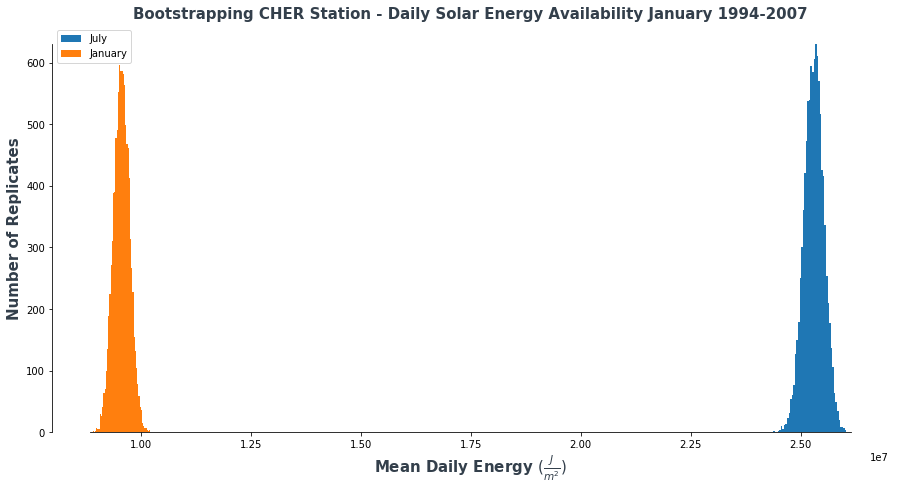

In [699]:
fig, ax = plt.subplots(figsize=(15,7.5))
plt.hist(energy_samples.meanenergy, bins=50)
plt.hist(energy_samples_jan.meanenergy, bins=50)

# Set titles and axes labels
ax.set_title("Bootstrapping CHER Station - Daily Solar Energy Availability January 1994-2007", fontsize=15, fontweight='black', color = '#333F4B')
ax.set_xlabel(r'Mean Daily Energy $(\frac{J}{m^2})$', fontsize=15, fontweight='black', color = '#333F4B')
ax.set_ylabel('Number of Replicates', fontsize=15, fontweight='black', color = '#333F4B')

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)

plt.legend(['July', 'January'])

plt.show()

- Comparison between January and July replicates shows the July replicate mean daily energy to be > 2x January.

### Bootstrap inference discussion
- Bootstrap inference has allowed us to generate an estimate of and confidence intervals for the mean daily energy availability at CHER station in July and January. 
- These models would allow a utility company to determine the expected range of daily energy for a given day.

# Bayesian Inference
- Bayesian inference has many uses in modelling data distributions.
- While the above bootstrap inference gave us a mean estimate with confidence intervals, the data was not modelled directly.
- Below, an attempt at modelling the CHER station January daily energy is made.

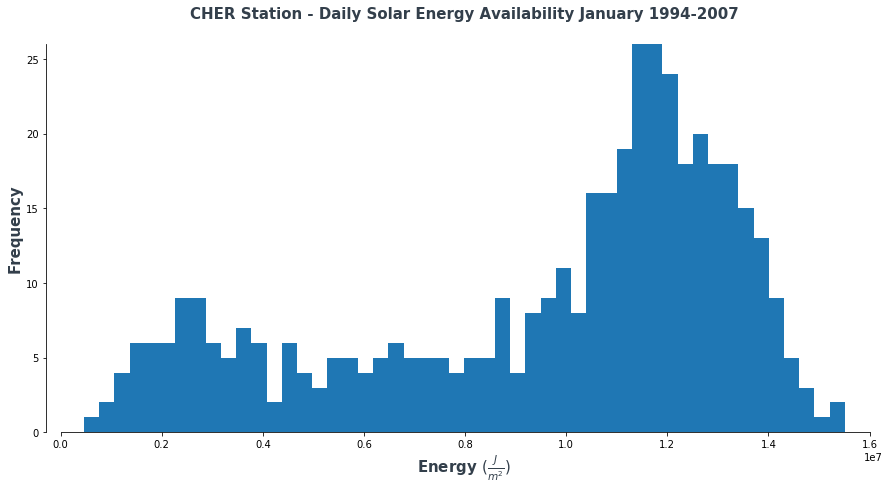

In [255]:
fig, ax = plt.subplots(figsize=(15,7.5))
plt.hist(cher_jan['energy'], bins=50)

# Set titles and axes labels
ax.set_title("CHER Station - Daily Solar Energy Availability January 1994-2007", fontsize=15, fontweight='black', color = '#333F4B')
ax.set_xlabel(r'Energy $(\frac{J}{m^2})$', fontsize=15, fontweight='black', color = '#333F4B')
ax.set_ylabel('Frequency', fontsize=15, fontweight='black', color = '#333F4B')

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)

plt.show()

- The distribution appears that it could be approximated by drawing from 3 normal distributions (with centers ~0.25e7, 0.7e7, and 1.2e7).
- We can use Pymc3 to model these distributions and their parameters.

In [580]:
# Set data as the CHER station January daily energy
data = cher_jan['energy'].reset_index()
del data['Date']

# Within the context of the model
with pm.Model() as model2:
    
    # Set p1, p2, p3 to be uniform priors between 0 and 1
    # These are the probabilities of being assigned to each of the 3 normal distributions
    # p1 + p2 + p3 must equal 1, this is done implicitly within pm.Categorical
    p1 = pm.Uniform('p', 0, 1)
    p2 = pm.Uniform('p2', 0, 1)
    p3 = pm.Uniform('p3', 0, 1)
    p = T.stack([p1, p2, p3])
    
    assignment = pm.Categorical("assignment", p, 
                                shape=data.energy.shape[0],
                                testval=np.random.randint(0, 3, data.energy.shape[0]))
    
print("prior assignment, with p1 = %.2f:" % p1.tag.test_value)
print(assignment.tag.test_value[:10])

prior assignment, with p1 = 0.50:
[2 2 1 2 1 2 0 0 1 1]


In [581]:
# Within the context of the model
with model2:
    
    # Set the standard deviations and the centers to be deterministic based on the assigned distribution
    sds = pm.Uniform("sds", 500000, 10000000, shape=3)
    centers = pm.Normal("centers",
                        mu=np.array([2500000, 6500000, 12000000]), 
                        sd=np.array([1000000, 5000000, 3000000]), 
                        shape=3)

    center_i = pm.Deterministic('center_i', centers[assignment])
    sd_i = pm.Deterministic('sd_i', sds[assignment])
    
    # Combine with the observations:
    observations = pm.Normal("obs", mu=center_i, sd=sd_i, observed=data.energy)
    
print("Random assignments: ", assignment.tag.test_value[:4], "...")
print("Assigned center: ", center_i.tag.test_value[:4], "...")
print("Assigned standard deviation: ", sd_i.tag.test_value[:4])

Random assignments:  [2 2 1 2] ...
Assigned center:  [12000000. 12000000.  6500000. 12000000.] ...
Assigned standard deviation:  [5250000. 5250000. 5250000. 5250000.]


In [582]:
with model2:
    
    # Get trace
    step1 = pm.Metropolis(vars=[p, sds, centers])
    step2 = pm.ElemwiseCategorical(vars=[assignment])
    start = pm.find_MAP()
    trace2 = pm.sample(50000, step=[step1, step2], start=start)

C:\Users\conno\Anaconda3\envs\Springboard\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning:

ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.

C:\Users\conno\Anaconda3\envs\Springboard\lib\site-packages\pymc3\tuning\starting.py:61: UserWarning:

find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.

logp = -7,956.9, ||grad|| = 86.482: 100%|█████████████████████████████████████████████| 11/11 [00:00<00:00, 648.09it/s]
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [centers]
>>Metropolis: [sds]
>>Metropolis: [p]
>>Metropolis: [p2]
>>Metropolis: [p3]
>ElemwiseCategorical: [assignment]
Sampling 4 chains: 100%|███████████████████████████████████████████████████| 202000/202000 [08:33<00:00, 393.11draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


In [735]:
def determine_proportions(assignment_trace):
    '''
    Takes an assignment trace and messily counts the proportions of assignments for each trace point 
    '''
    p0 = np.zeros(assignment_trace.shape[0])
    p1 = np.zeros(assignment_trace.shape[0])
    p2 = np.zeros(assignment_trace.shape[0])

    for i in range(assignment_trace.shape[0]):

        unique, counts = np.unique(assignment_trace[i,:], return_counts=True)

        total = sum(counts)
        num_unique = len(unique)

        if num_unique == 3:
            p0[i] = counts[0] / total
            p1[i] = counts[1] / total
            p2[i] = counts[2] / total
        else:
            unique_1 = unique[0]
            unique_2 = unique[1]
            unique_missing = 3 - unique_1 - unique_2

            if unique_missing == 0:
                p0[i] = 0
                p1[i] = counts[0] / total
                p2[i] = counts[1] / total

            if unique_missing == 1:
                p0[i] = counts[0] / total
                p1[i] = 0
                p2[i] = counts[1] / total

            if unique_missing == 2:
                p0[i] = counts[0] / total
                p1[i] = counts[1] / total
                p2[i] = 0
                
    return p0, p1, p2

In [736]:
# Get the proportions of assignments for trace
assignment_trace = trace2["assignment"]
p0, p1, p2 = determine_proportions(assignment_trace)

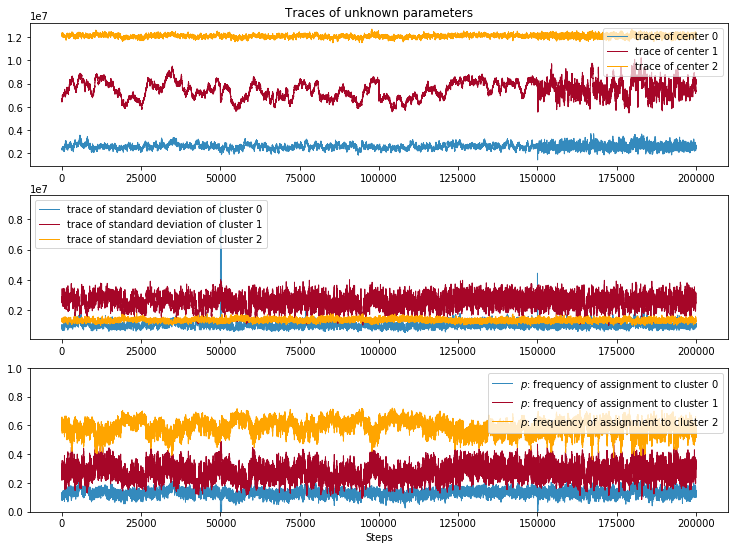

In [737]:
# Plot traces of centers, standard deviations, and proportions of assignments

figsize(12.5, 9)
plt.subplot(311)
lw = 1
center_trace = trace2["centers"]

# for pretty colors later in the book.
colors = ["#348ABD", "#A60628", 'orange'] 

plt.plot(center_trace[:, 0], label="trace of center 0", c=colors[0], lw=lw)
plt.plot(center_trace[:, 1], label="trace of center 1", c=colors[1], lw=lw)
plt.plot(center_trace[:, 2], label="trace of center 2", c='orange', lw=lw)
plt.title("Traces of unknown parameters")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.7)

plt.subplot(312)
std_trace = trace2["sds"]
plt.plot(std_trace[:, 0], label="trace of standard deviation of cluster 0",
     c=colors[0], lw=lw)
plt.plot(std_trace[:, 1], label="trace of standard deviation of cluster 1",
     c=colors[1], lw=lw)
plt.plot(std_trace[:, 2], label="trace of standard deviation of cluster 2",
     c='orange', lw=lw)
plt.legend(loc="upper left")

plt.subplot(313)
p_trace = trace2["p"]
plt.plot(p0, label="$p$: frequency of assignment to cluster 0",
     color=colors[0], lw=lw)
plt.plot(p1, label="$p$: frequency of assignment to cluster 1",
     color=colors[1], lw=lw)
plt.plot(p2, label="$p$: frequency of assignment to cluster 2",
     color=colors[2], lw=lw)

plt.xlabel("Steps")
plt.ylim(0, 1)
plt.legend();


- The traces of centers 0 and 2 appear to have converged to distributions, while center 1 has poor convergence (though it does explore around a somewhat constrained distribution of values).
- Standard deviations and frequency of assignments appear to have good convergence. 

In [738]:
# Count the overall proportions of values assigned to different distributions
unique, counts = np.unique(trace2["assignment"], return_counts=True)
print(np.asarray((unique, counts)).T)

total = sum(counts)
proportions = [counts[0] / total, counts[1] / total, counts[2] / total]
proportions

[[       0 11853743]
 [       1 23587960]
 [       2 51358297]]


[0.1365638594470046, 0.2717506912442396, 0.5916854493087558]

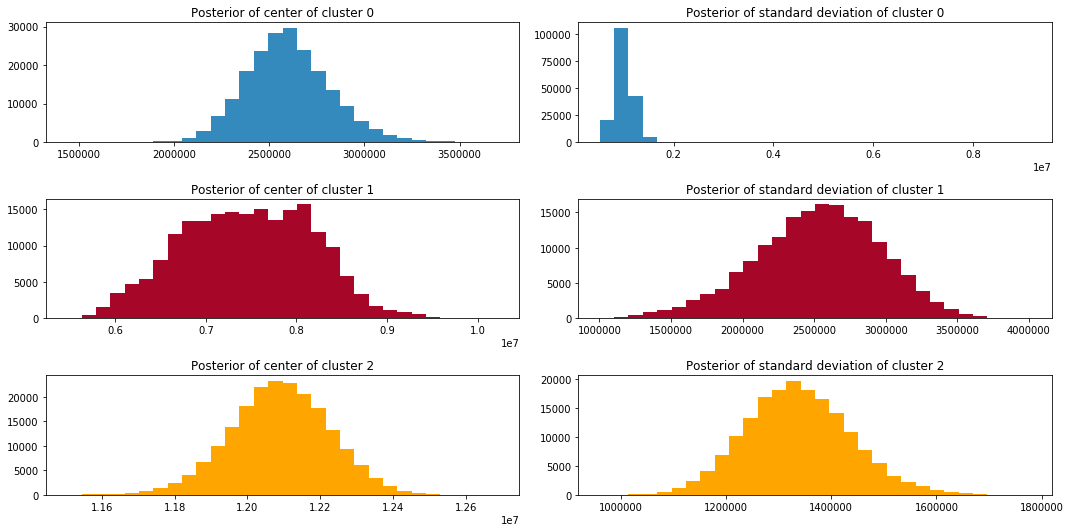

In [739]:
# Plot the posterior histograms

figsize(15, 7.5)
std_trace = trace2["sds"][25000:]
prev_std_trace = trace2["sds"][:25000]

_i = [1, 2, 3, 4, 5, 6]
for i in range(3):
    
    plt.subplot(3, 2, _i[2 * i])
    plt.title("Posterior of center of cluster %d" % i)
    plt.hist(center_trace[:, i], color=colors[i], bins=30,
             histtype="stepfilled")

    plt.subplot(3, 2, _i[2 * i + 1])
    plt.title("Posterior of standard deviation of cluster %d" % i)
    plt.hist(std_trace[:, i], color=colors[i], bins=30,
             histtype="stepfilled")

plt.tight_layout()

- All posterior distributions appear normally distributed except for the center of cluster 1 - this distribution is wider, indicating poor convergence.

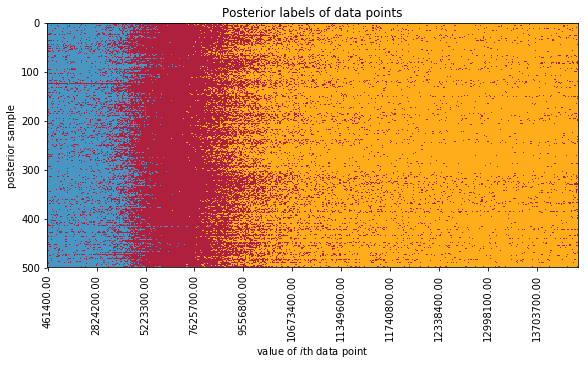

In [740]:
# Plot the assignments according to data values

import matplotlib as mpl
figsize(12.5, 4.5)
plt.cmap = mpl.colors.ListedColormap(colors)
plt.imshow(trace2["assignment"][::400, np.argsort(data.energy)],
       cmap=plt.cmap, aspect=.4, alpha=.9)
plt.xticks(np.arange(0, data.energy.shape[0], 40),
       ["%.2f" % s for s in np.sort(data.energy)[::40]], rotation=90)
plt.ylabel("posterior sample")
plt.xlabel("value of $i$th data point")
plt.title("Posterior labels of data points");

- As the value of the datapoints increases, they are more likely to be assigned to clusters 1 and 2. Cluster 1 has values assigned to it from the entire range of data.

In [733]:
posterior_std_means

array([1017629.35798751, 2534572.1514209 , 1336372.19303885])

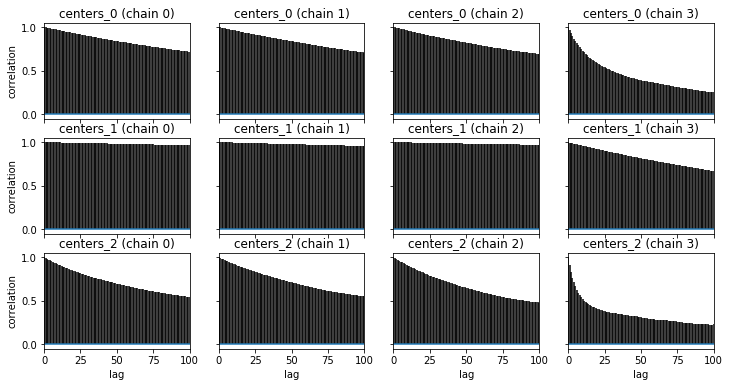

In [593]:
# Plot autocorrelation plots 
pm.autocorrplot(trace2, varnames=['centers'])
plt.show()

- The centers of distribution 1 have high autocorrelation which sugguests that the space was poorly explored.

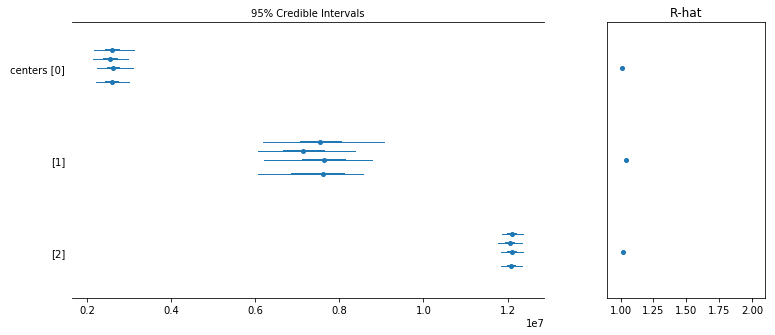

In [594]:
pm.forestplot(trace2, varnames=['centers'])
plt.show()

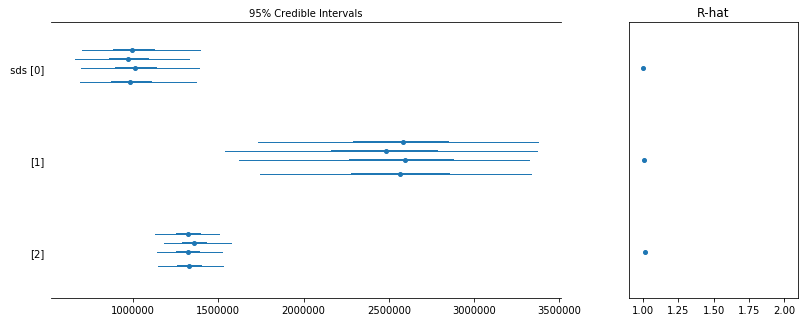

In [595]:
pm.forestplot(trace2, varnames=['sds'])
plt.show()

- R-hat values are close to 1 as desired.
- 95% credible intervals are tighter for centers 0 and 2 than for center 1.
- The 95% credible intervals for the standard deviation has a wide range - this is understandable, given that the distribution is nested between two others - it is difficult to say how wide the distribution is.

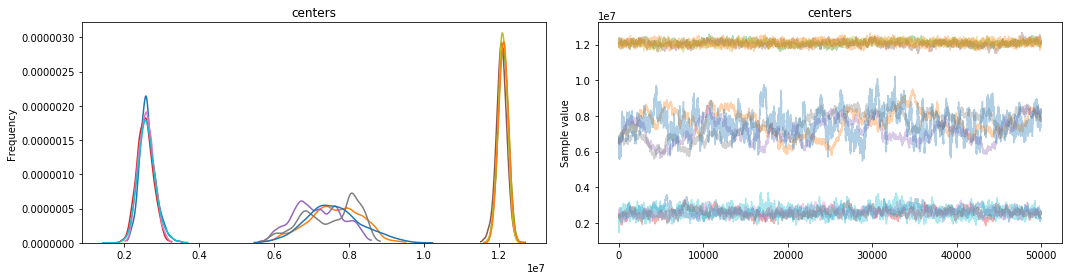

In [626]:
pm.plots.traceplot(figsize=(15, 4), trace=trace2, varnames=["centers"])

plt.show()

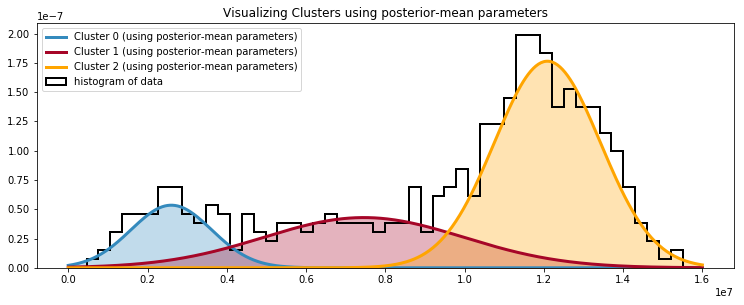

In [741]:
# Plot histogram of the data along with posterior distributions
# (scaled according to probability of being assigned to that distribution)

norm = stats.norm
x = np.linspace(0, 16000000, 500)
posterior_center_means = center_trace.mean(axis=0)
posterior_std_means = std_trace.mean(axis=0)

plt.hist(data.energy, bins=50, histtype="step", density=True, color='k',
     lw=2, label="histogram of data")
y = proportions[0] * norm.pdf(x, loc=posterior_center_means[0],
                                scale=posterior_std_means[0])
plt.plot(x, y, label="Cluster 0 (using posterior-mean parameters)", lw=3, color=colors[0])
plt.fill_between(x, y, color=colors[0], alpha=0.3)

y = proportions[1] * norm.pdf(x, loc=posterior_center_means[1],
                                      scale=posterior_std_means[1])
plt.plot(x, y, label="Cluster 1 (using posterior-mean parameters)", lw=3, color=colors[1])
plt.fill_between(x, y, color=colors[1], alpha=0.3)

y = proportions[2] * norm.pdf(x, loc=posterior_center_means[2],
                                      scale=posterior_std_means[2])
plt.plot(x, y, label="Cluster 2 (using posterior-mean parameters)", lw=3, color=colors[2])
plt.fill_between(x, y, color=colors[2], alpha=0.3)

plt.legend(loc="upper left")
plt.title("Visualizing Clusters using posterior-mean parameters");

- The above plot shows that it is plausible to draw from the 3 posterior distributions to obtain the observed data.

In [742]:
best_shot_simulated = np.zeros(len(data.energy))
assignment_simulated = np.zeros(len(data.energy))

for i in range(len(data.energy)):
    assignment_simulated[i] = np.random.choice(np.arange(0, 3), p=[proportions[0], proportions[1], proportions[2]])

In [743]:
for i in range(len(data.energy)):
    assignment = assignment_simulated[i]
    
    if assignment == 0.:
        best_shot_simulated[i] = norm.rvs(posterior_center_means[0], posterior_std_means[0])
    elif assignment == 1.:
        best_shot_simulated[i] = norm.rvs(posterior_center_means[1], posterior_std_means[1])
    else:
        best_shot_simulated[i] = norm.rvs(posterior_center_means[2], posterior_std_means[2])

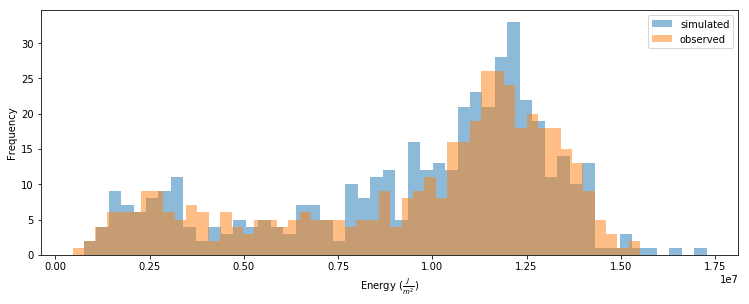

In [746]:
_ = plt.hist(best_shot_simulated, bins=50, alpha=0.5, label='simulated')
_ = plt.hist(data.energy, bins=50, alpha=0.5, label='observed')
_ = plt.xlabel(r'Energy $(\frac{J}{m^2})$')
_ = plt.ylabel('Frequency')
_ = plt.legend()

- The simulated data compares very well with the observed data.
- This result suggests the model may be able to be used to model daily energy at CHER station in January.

### Testing a model with 2 distributions instead of 3

In [629]:
data = cher_jan['energy'].reset_index()
del data['Date']

import pymc3 as pm
import theano.tensor as T

with pm.Model() as model:
    p1 = pm.Uniform('p', 0, 1)
    p2 = 1 - p1
    p = T.stack([p1, p2])
    assignment = pm.Categorical("assignment", p, 
                                shape=data.energy.shape[0],
                                testval=np.random.randint(0, 2, data.energy.shape[0]))
    
print("prior assignment, with p = %.2f:" % p1.tag.test_value)
print(assignment.tag.test_value[:10])

prior assignment, with p = 0.50:
[1 0 1 0 0 1 1 1 1 0]


In [630]:
with model:
    sds = pm.Uniform("sds", 500000, 10000000, shape=2)
    centers = pm.Normal("centers",
                        mu=np.array([2500000, 12000000]), 
                        sd=np.array([1000000, 3000000]), 
                        shape=2)
    
    center_i = pm.Deterministic('center_i', centers[assignment])
    sd_i = pm.Deterministic('sd_i', sds[assignment])
    
    # and to combine it with the observations:
    observations = pm.Normal("obs", mu=center_i, sd=sd_i, observed=data.energy)
    
print("Random assignments: ", assignment.tag.test_value[:4], "...")
print("Assigned center: ", center_i.tag.test_value[:4], "...")
print("Assigned standard deviation: ", sd_i.tag.test_value[:4])

Random assignments:  [1 0 1 0] ...
Assigned center:  [12000000.  2500000. 12000000.  2500000.] ...
Assigned standard deviation:  [5250000. 5250000. 5250000. 5250000.]


In [631]:
with model:
    step1 = pm.Metropolis(vars=[p, sds, centers])
    step2 = pm.ElemwiseCategorical(vars=[assignment])
    start = pm.find_MAP()
    trace = pm.sample(50000, step=[step1, step2], start=start)

C:\Users\conno\Anaconda3\envs\Springboard\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning:

ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.

C:\Users\conno\Anaconda3\envs\Springboard\lib\site-packages\pymc3\tuning\starting.py:61: UserWarning:

find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.

logp = -7,807.1, ||grad|| = 130.45: 100%|████████████████████████████████████████████| 10/10 [00:00<00:00, 1432.48it/s]
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [centers]
>>Metropolis: [sds]
>>Metropolis: [p]
>ElemwiseCategorical: [assignment]
Sampling 4 chains: 100%|███████████████████████████████████████████████████| 202000/202000 [07:20<00:00, 458.41draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


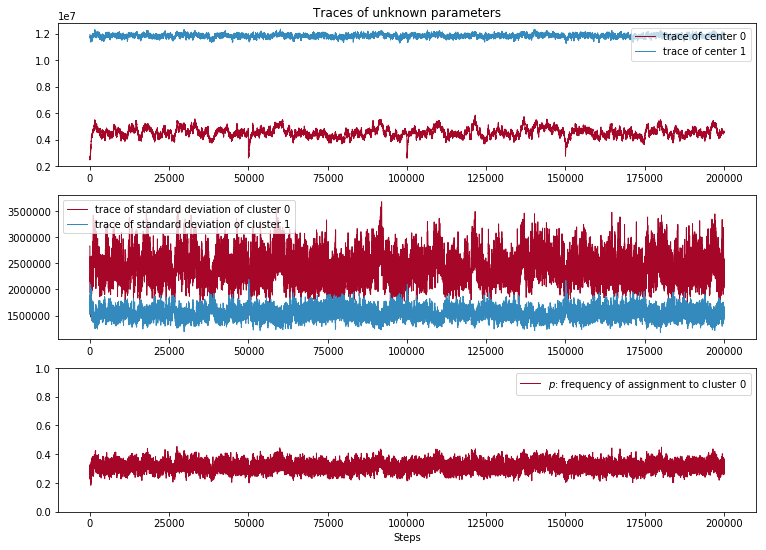

In [688]:
from IPython.core.pylabtools import figsize

figsize(12.5, 9)
plt.subplot(311)
lw = 1
center_trace = trace["centers"]

# for pretty colors later in the book.
colors = ["#348ABD", "#A60628"] if center_trace[-1, 0] > center_trace[-1, 1] \
    else ["#A60628", "#348ABD"]

plt.plot(center_trace[:, 0], label="trace of center 0", c=colors[0], lw=lw)
plt.plot(center_trace[:, 1], label="trace of center 1", c=colors[1], lw=lw)
plt.title("Traces of unknown parameters")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.7)

plt.subplot(312)
std_trace = trace["sds"]
plt.plot(std_trace[:, 0], label="trace of standard deviation of cluster 0",
     c=colors[0], lw=lw)
plt.plot(std_trace[:, 1], label="trace of standard deviation of cluster 1",
     c=colors[1], lw=lw)
plt.legend(loc="upper left")

plt.subplot(313)
p_trace = trace["p"]
plt.plot(p_trace, label="$p$: frequency of assignment to cluster 0",
     color=colors[0], lw=lw)
plt.xlabel("Steps")
plt.ylim(0, 1)
plt.legend();


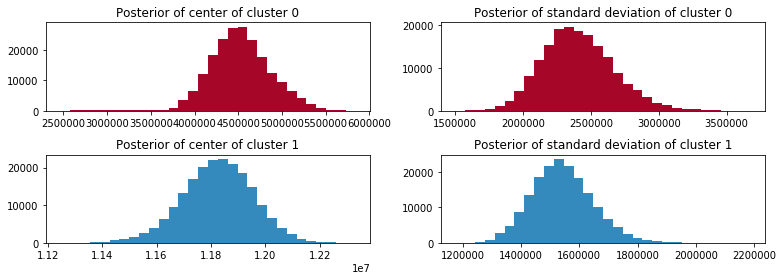

In [689]:
figsize(11.0, 4)
std_trace = trace["sds"][25000:]
prev_std_trace = trace["sds"][:25000]

_i = [1, 2, 3, 4]
for i in range(2):
    plt.subplot(2, 2, _i[2 * i])
    plt.title("Posterior of center of cluster %d" % i)
    plt.hist(center_trace[:, i], color=colors[i], bins=30,
             histtype="stepfilled")

    plt.subplot(2, 2, _i[2 * i + 1])
    plt.title("Posterior of standard deviation of cluster %d" % i)
    plt.hist(std_trace[:, i], color=colors[i], bins=30,
             histtype="stepfilled")
    # plt.autoscale(tight=True)

plt.tight_layout()

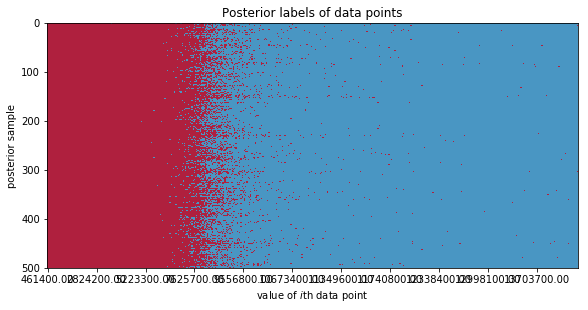

In [690]:
import matplotlib as mpl
figsize(12.5, 4.5)
plt.cmap = mpl.colors.ListedColormap(colors)
plt.imshow(trace["assignment"][::400, np.argsort(data.energy)],
       cmap=plt.cmap, aspect=.4, alpha=.9)
plt.xticks(np.arange(0, data.energy.shape[0], 40),
       ["%.2f" % s for s in np.sort(data.energy)[::40]])
plt.ylabel("posterior sample")
plt.xlabel("value of $i$th data point")
plt.title("Posterior labels of data points");

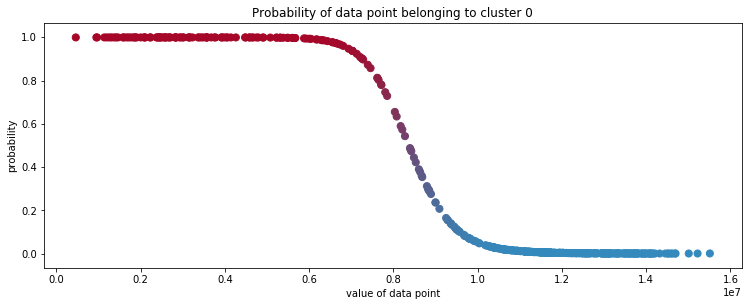

In [691]:
cmap = mpl.colors.LinearSegmentedColormap.from_list("BMH", colors)
assign_trace = trace["assignment"]
plt.scatter(data.energy, 1 - assign_trace.mean(axis=0), cmap=cmap,
        c=assign_trace.mean(axis=0), s=50)
#plt.ylim(-0.05, 1.05)
#plt.xlim(35, 300)
plt.title("Probability of data point belonging to cluster 0")
plt.ylabel("probability")
plt.xlabel("value of data point");

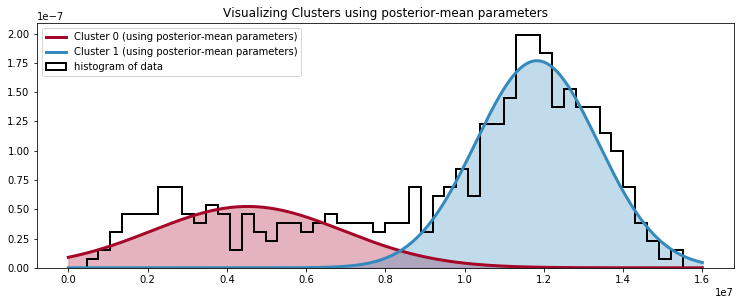

In [692]:
import scipy.stats as stats
norm = stats.norm
x = np.linspace(0, 16000000, 500)
posterior_center_means = center_trace.mean(axis=0)
posterior_std_means = std_trace.mean(axis=0)
posterior_p_mean = trace["p"].mean()

plt.hist(data.energy, bins=50, histtype="step", density=True, color='k',
     lw=2, label="histogram of data")
y = posterior_p_mean * norm.pdf(x, loc=posterior_center_means[0],
                                scale=posterior_std_means[0])
plt.plot(x, y, label="Cluster 0 (using posterior-mean parameters)", lw=3, color=colors[0])
plt.fill_between(x, y, color=colors[0], alpha=0.3)

y = (1 - posterior_p_mean) * norm.pdf(x, loc=posterior_center_means[1],
                                      scale=posterior_std_means[1])
plt.plot(x, y, label="Cluster 1 (using posterior-mean parameters)", lw=3, color=colors[1])
plt.fill_between(x, y, color=colors[1], alpha=0.3)

plt.legend(loc="upper left")
plt.title("Visualizing Clusters using posterior-mean parameters");

# Alternative correlation matrices 
- Experimentation with alternative methods of visualizing correlation.

In [9]:
# Copy EDA_data 
corr_half = EDA_data_t0.corr()

# Set all values above matrix diagonal to 0
for i in range(19):
        corr_half.iloc[i,i:] = 0

# Set all values exactly equal to 0 to NaN - this is so they will not be plotted below     
arr = np.where(np.isclose(corr_half.values, 0.0000), np.nan, corr_half.values)
corr_half = pd.DataFrame(arr, index=corr_half.index, columns=corr_half.columns)

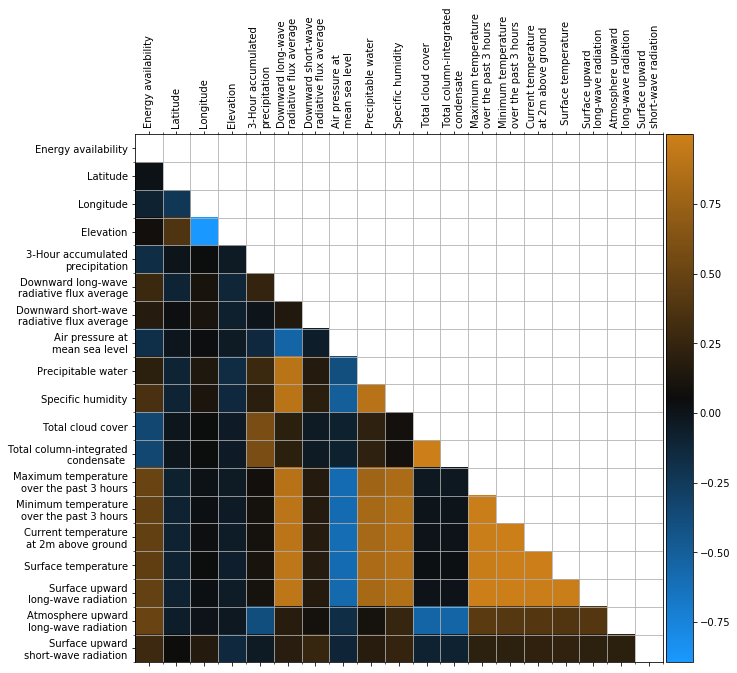

In [10]:
# Set color map
clist = [(0.1, 0.6, 1.0), (0.05, 0.05, 0.05), (0.8, 0.5, 0.1)]
cmap = LinearSegmentedColormap.from_list("cmap_name", clist)

# Set column labels
column_labels = ['Energy availability', 'Latitude', 'Longitude', 'Elevation','3-Hour accumulated\nprecipitation', 'Downward long-wave\nradiative flux average','Downward short-wave\nradiative flux average', 'Air pressure at\nmean sea level','Precipitable water', 'Specific humidity','Total cloud cover', 'Total column-integrated\ncondensate ','Maximum temperature\nover the past 3 hours', 'Minimum temperature\nover the past 3 hours','Current temperature\nat 2m above ground', ' Surface temperature','Surface upward\nlong-wave radiation', 'Atmosphere upward\nlong-wave radiation','Surface upward\nshort-wave radiation']

# Plot correlation matrix
f = plt.figure(figsize=(10, 10))
plt.matshow(corr_half, fignum=f.number, cmap=cmap)
plt.xticks(range(EDA_data_t0.shape[1]), labels=column_labels, fontsize=10, rotation=90, multialignment='left')
plt.yticks(range(EDA_data_t0.shape[1]), labels=column_labels, fontsize=10)

ax = f.gca()
ax.grid(False, 'major')
ax.grid(True, 'minor')
ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax=cax)

plt.show()

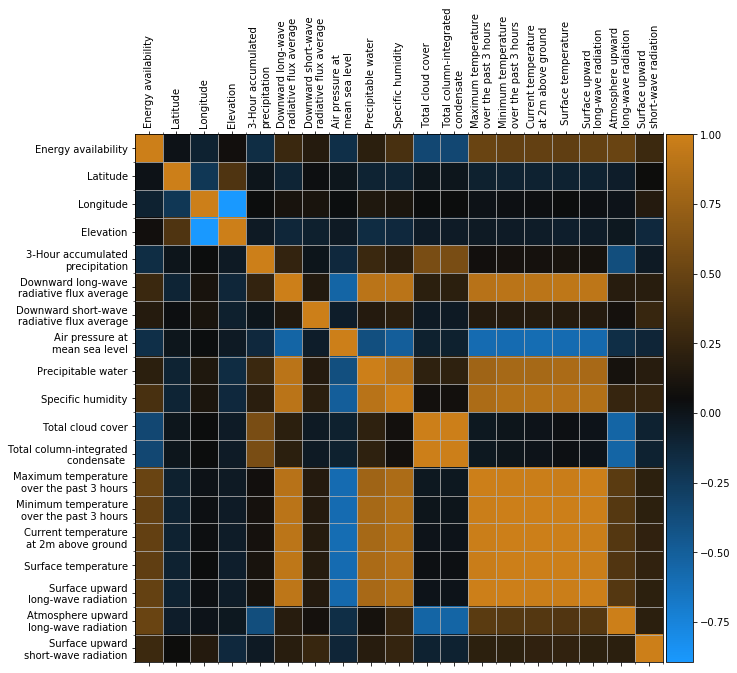

In [11]:

clist = [(0.1, 0.6, 1.0), (0.05, 0.05, 0.05), (0.8, 0.5, 0.1)]
cmap = LinearSegmentedColormap.from_list("cmap_name", clist)

column_labels = ['Energy availability', 'Latitude', 'Longitude', 'Elevation','3-Hour accumulated\nprecipitation', 'Downward long-wave\nradiative flux average','Downward short-wave\nradiative flux average', 'Air pressure at\nmean sea level','Precipitable water', 'Specific humidity','Total cloud cover', 'Total column-integrated\ncondensate ','Maximum temperature\nover the past 3 hours', 'Minimum temperature\nover the past 3 hours','Current temperature\nat 2m above ground', ' Surface temperature','Surface upward\nlong-wave radiation', 'Atmosphere upward\nlong-wave radiation','Surface upward\nshort-wave radiation']

f = plt.figure(figsize=(10, 10))
plt.matshow(EDA_data_t0.corr(), fignum=f.number, cmap=cmap)
plt.xticks(range(EDA_data_t0.shape[1]), labels=column_labels, fontsize=10, rotation=90, multialignment='left')
plt.yticks(range(EDA_data_t0.shape[1]), labels=column_labels, fontsize=10)

ax = f.gca()
ax.grid(False, 'major')
ax.grid(True, 'minor')
ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(cax=cax)

#cb = plt.colorbar()
#cb.ax.tick_params(labelsize=8)
#plt.title('Correlation Matrix', fontsize=16);
#plt.margins(0.05)

plt.show()

In [12]:
corr_coef = EDA_data_t0.corr()
corr_coef[corr_coef > 0.9]

,energy,nlat,elon,elev,apcp_sfc_fhour0,dlwrf_sfcfhour0,dswrf_sfcfhour0,pres_msl_fhour0,pwat_eatmfhour0,spfh_2m_lfhour0,tcdc_eatmfhour0,tcolc_eatfhour0,tmax_2m_lfhour0,tmin_2m_lfhour0,tmp_2m_lafhour0,tmp_sfc_lfhour0,ulwrf_sfcfhour0,ulwrf_tatfhour0,uswrf_sfcfhour0
energy,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nlat,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
elon,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
elev,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
apcp_sfc_fhour0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dlwrf_sfcfhour0,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,0.909054,0.910505,NaN,NaN,NaN,0.911085,0.915061,0.929495,0.920508,NaN,NaN
dswrf_sfcfhour0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pres_msl_fhour0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pwat_eatmfhour0,NaN,NaN,NaN,NaN,NaN,0.909054,NaN,NaN,1.000000,0.900439,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
spfh_2m_lfhour0,NaN,NaN,NaN,NaN,NaN,0.910505,NaN,NaN,0.900439,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
